In [1]:
# Standard Library Imports
import re
import warnings
import logging


# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties

# Text Processing
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from urlextract import URLExtract
from tqdm import tqdm

# Machine Learning - Model Selection and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier, SGDClassifier, Perceptron

# Suppressing Warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../../../Data/English/1. Main/english_sms.csv", encoding='latin1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

In [5]:
# drop last 3 columns; which are not usefull
df = df[["v1","v2"]]

In [6]:
# rename columns names
df.rename(columns={"v1":"Class", "v2":"Text"}, inplace=True)

In [7]:
# Check for duplicates and remove them if found
if df.duplicated().sum() > 0:
    print("Found duplicate rows. Removing them...")
    df = df.drop_duplicates()

Found duplicate rows. Removing them...


In [8]:
# Check for missing values
missing_values = df.isna().sum()
if missing_values.any():
    print("Found missing values. Removing them...")
    df = df.dropna()

In [9]:
df.shape

(5169, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   5169 non-null   object
 1   Text    5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [11]:
# adding some usfule columns to the dataset

# number of words in a message
df['NO_words'] = df['Text'].apply(lambda x:len(nltk.word_tokenize(x)))

# number of characters in a message
df['NO_characters'] = df['Text'].apply(len)

# number of sentence in message
df['NO_sentences'] = df['Text'].apply(lambda x:len(nltk.sent_tokenize(x)))


In [12]:
df.head()

,Class,Text,NO_words,NO_characters,NO_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",24,111,2
1,ham,Ok lar... Joking wif u oni...,8,29,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,37,155,2
3,ham,U dun say so early hor... U c already then say...,13,49,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",15,61,1


In [13]:
# Descriptive statistics of text features
df.describe()

,NO_words,NO_characters,NO_sentences
count,5169.000000,5169.000000,5169.000000
mean,18.455794,78.977945,1.965564
std,13.324758,58.236293,1.448541
min,1.000000,2.000000,1.000000
25%,9.000000,36.000000,1.000000
50%,15.000000,60.000000,1.000000
75%,26.000000,117.000000,2.000000
max,220.000000,910.000000,38.000000


In [14]:
# Descriptive statistics of text features for HAM messages
df[df['Class'] == "ham"][['NO_characters', 'NO_words', 'NO_sentences']].describe()

,NO_characters,NO_words,NO_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [15]:
# Descriptive statistics of text features for SPAM messages
df[df['Class'] == "spam"][['NO_characters', 'NO_words', 'NO_sentences']].describe()

,NO_characters,NO_words,NO_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


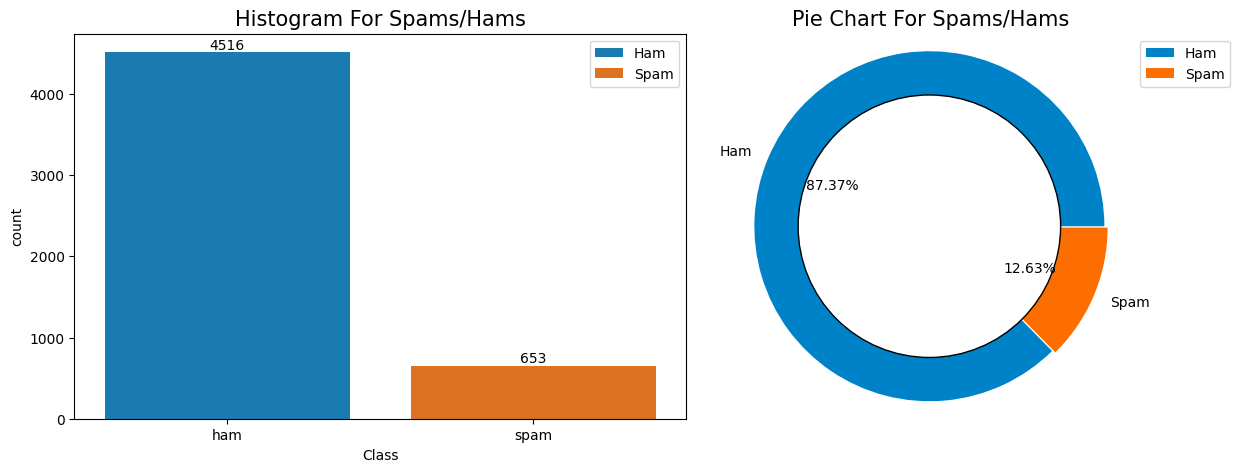

In [16]:
# Calculate number of each class (ham or spam)
spam_count = df['Class'].value_counts()['spam']
ham_count = df['Class'].value_counts()['ham']

# Color settings
hist_colors = ['#0082c8', '#fc6e00']
pie_colors = ['#0082c8', '#fc6e00']

# Plotting
labels = ['Ham', 'Spam']
plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Class', hue='Class', alpha=1, palette=hist_colors)
plt.legend(labels)
plt.title('Histogram For Spams/Hams', size=15)

# Annotate histogram with exact counts
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Pie Chart
plt.subplot(1, 2, 2)
sizes = [ham_count, spam_count]
explode = [0, 0.02]
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.2f%%', colors=pie_colors)
plt.axis('equal')
plt.legend(labels)
circle = plt.Circle(xy=(0, 0), radius=0.75, facecolor='white', edgecolor='black')
plt.gca().add_artist(circle)
plt.title('Pie Chart For Spams/Hams', size=15)

# Adjust layout to bring subplots closer together
plt.subplots_adjust(wspace= -0.1)  # Reduce the value to bring plots closer

# # Save the plot with higher quality
plt.savefig('../../../Data/English/1. Main/F_Spam_vs_Ham_distribution.png', format='png', dpi=1000)

plt.show()


### "The dataset is heavily imbalanced, with ham messages comprising 87.37% (4516 messages) and spam messages making up 12.63% (653 messages)."






.



.



.

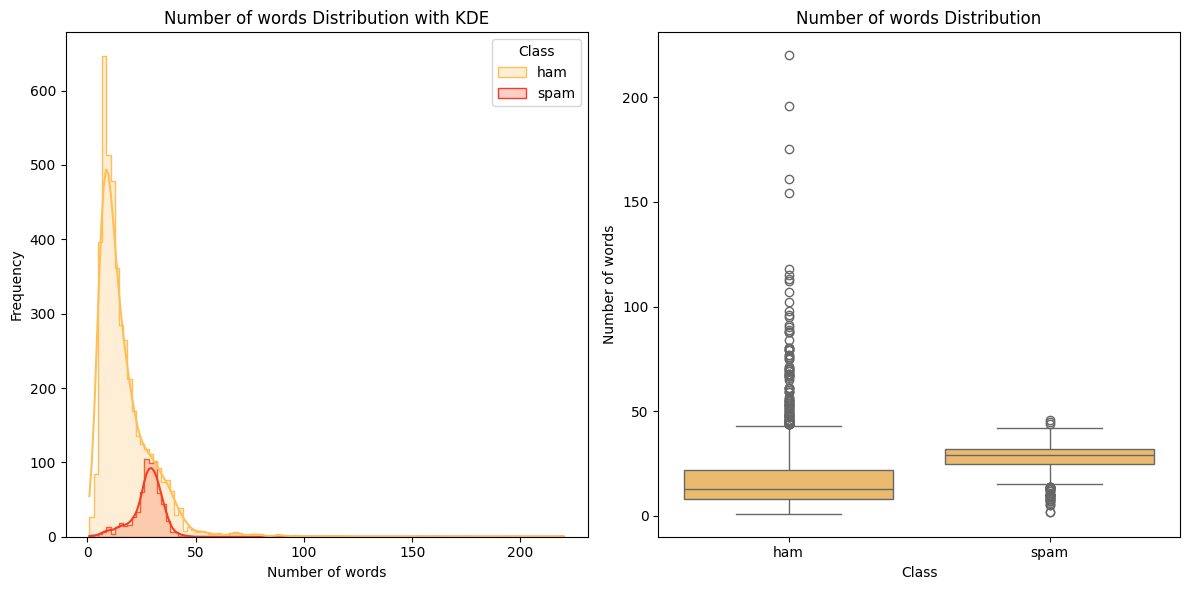

In [17]:
plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.histplot(data=df, x='NO_words', hue='Class', kde=True, element='step')
plt.title('Number of words Distribution with KDE')
# plt.xticks(range(0, df['NO_words'].max() + 1, 10))  # Adjust the step size as needed
plt.xlabel('Number of words')
plt.ylabel('Frequency')

# Second subplot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_words', data=df)
plt.title('Number of words Distribution')
plt.xlabel('Class')
plt.ylabel('Number of words')

# Adjust layout
plt.tight_layout()

# # Save the plot with higher quality
plt.savefig('../../../Data/English/1. Main/Number of words Distribution.png', format='png', dpi=1000)

# Show the plots
plt.show()

## Analysis:
1.	Ham Messages: The KDE plot on the left shows that the majority of ham messages contain fewer than 50 words, with a sharp peak around 5-10 words. The box plot on the right indicates that the median number of words in ham messages is around 10, with a considerable range and several outliers extending up to about 200 words.
2.	Spam Messages: The KDE plot indicates that spam messages also typically contain fewer than 50 words, but the peak is slightly higher around 10-20 words. The box plot reveals that the median number of words in spam messages is higher than that of ham, approximately around 20 words, with fewer extreme outliers compared to ham messages.
## Descriptive Sentence:
### "Ham messages generally contain fewer words, with a median of about 10 words and a significant number of outliers, indicating occasional longer messages. In contrast, spam messages have a higher median word count of around 20 words, suggesting that spam messages are typically longer but with fewer extreme outliers compared to ham."

.



.



.



.


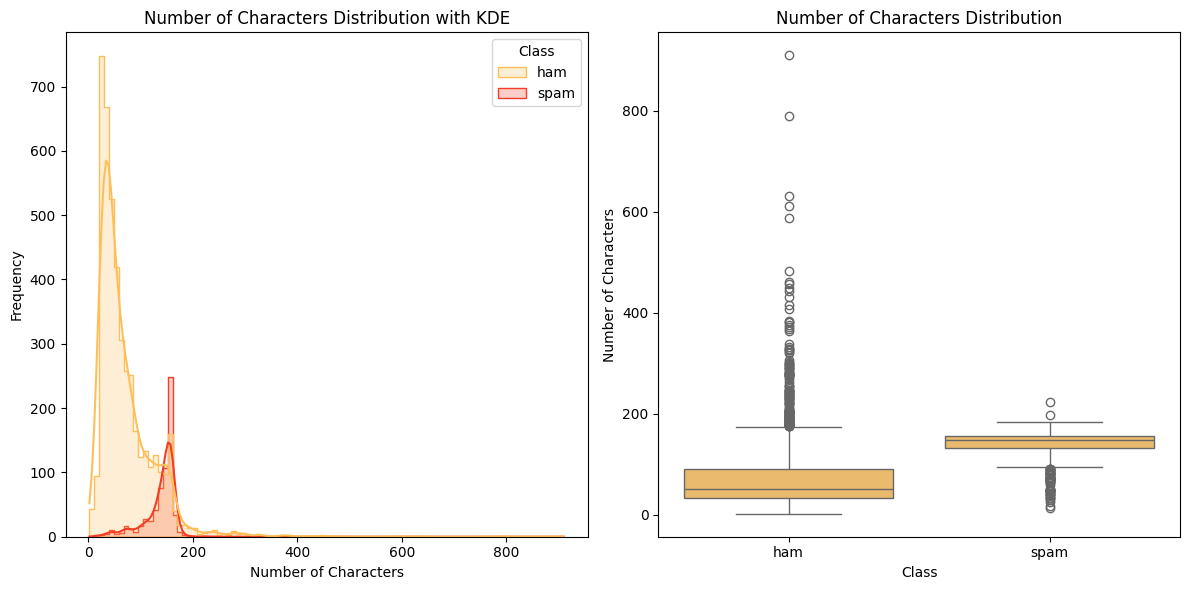

In [18]:
plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.histplot(data=df, x='NO_characters', hue='Class', kde=True, element='step')
plt.title('Number of Characters Distribution with KDE')
# plt.xticks(range(0, df['NO_characters'].max() + 1, 50))  # Adjust the step size as needed
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

# Second subplot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_characters', data=df)
plt.title('Number of Characters Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Characters')

# Adjust layout
plt.tight_layout()

# # Save the plot with higher quality
plt.savefig('../../../Data/English/1. Main/Number of Characters.png', format='png', dpi=1000)

# Show the plots
plt.show()

## Analysis:
1.	Ham Messages: The left panel (KDE plot) demonstrates that the number of characters in ham messages typically ranges between 0 and 200, with a sharp peak around 50 characters. The right panel (box plot) shows that the median number of characters in ham messages is around 50, with a considerable number of outliers extending up to around 800 characters.
2.	Spam Messages: The KDE plot indicates that spam messages tend to have a higher number of characters compared to ham, with a peak around 150 characters. The box plot reveals that the median number of characters in spam messages is higher than that of ham, with fewer extreme outliers.
## Descriptive Sentence:
### "Spam messages tend to be longer, typically around 150 characters, compared to ham messages, which have a median length of about 50 characters. The distribution of ham messages shows more extreme outliers, indicating occasional longer messages."




.





.





.




.

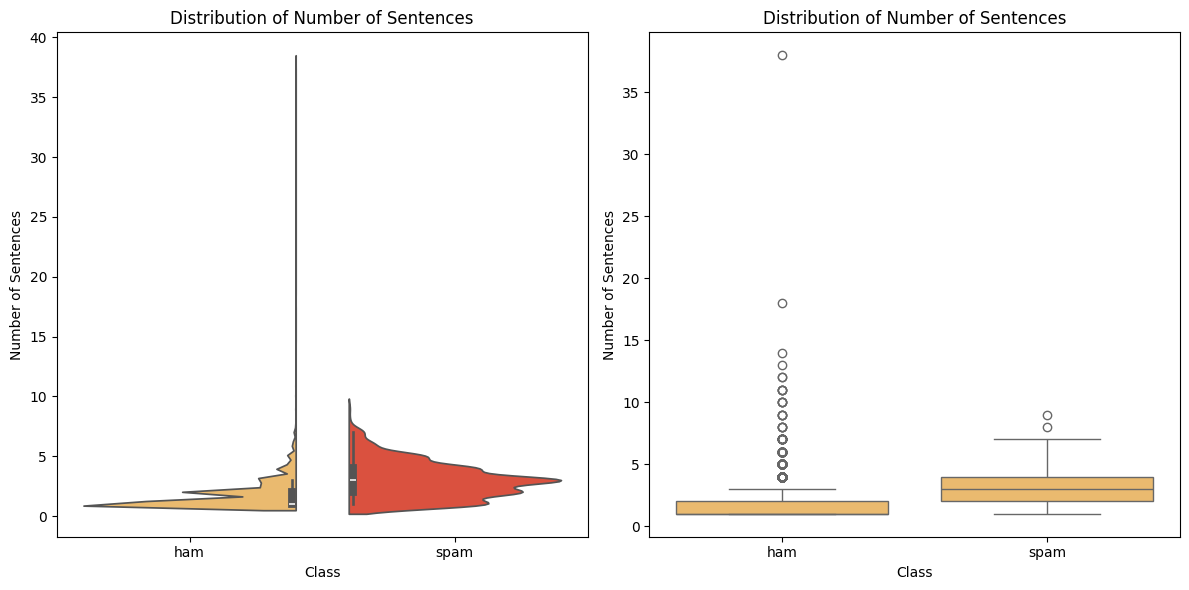

In [19]:

plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot - Violin Plot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.violinplot(data=df, x='Class', y='NO_sentences', hue='Class', split=True)
plt.title('Distribution of Number of Sentences')
plt.xlabel('Class')
plt.ylabel('Number of Sentences')

# Second subplot - Box Plot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_sentences', data=df)
plt.title('Distribution of Number of Sentences')
plt.xlabel('Class')
plt.ylabel('Number of Sentences')

# Adjust layout
plt.tight_layout()

# # Save the plot with higher quality
plt.savefig('../../../Data/English/1. Main/Number of sentenc.png', format='png', dpi=1000)

# Show the plots
plt.show()

## Analysis:
1.	Ham Messages: The left panel (distribution plot) shows that the majority of ham (non-spam) messages have a low number of sentences, mostly between 1 and 5. The right panel (box plot) indicates that the median number of sentences in ham messages is around 1, with a few outliers having a higher number of sentences.
2.	Spam Messages: The distribution plot indicates that spam messages also tend to have a low number of sentences, but there is a slightly higher concentration around 1 to 2 sentences compared to ham. The box plot shows that the median number of sentences in spam messages is also around 1, but with fewer outliers compared to ham.
## Descriptive Sentence:
### "Most ham and spam messages contain only 1 to 2 sentences, indicating that both types of messages are generally concise. However, ham messages show more variability and outliers, suggesting that they occasionally contain more detailed content."


.




.




.




.

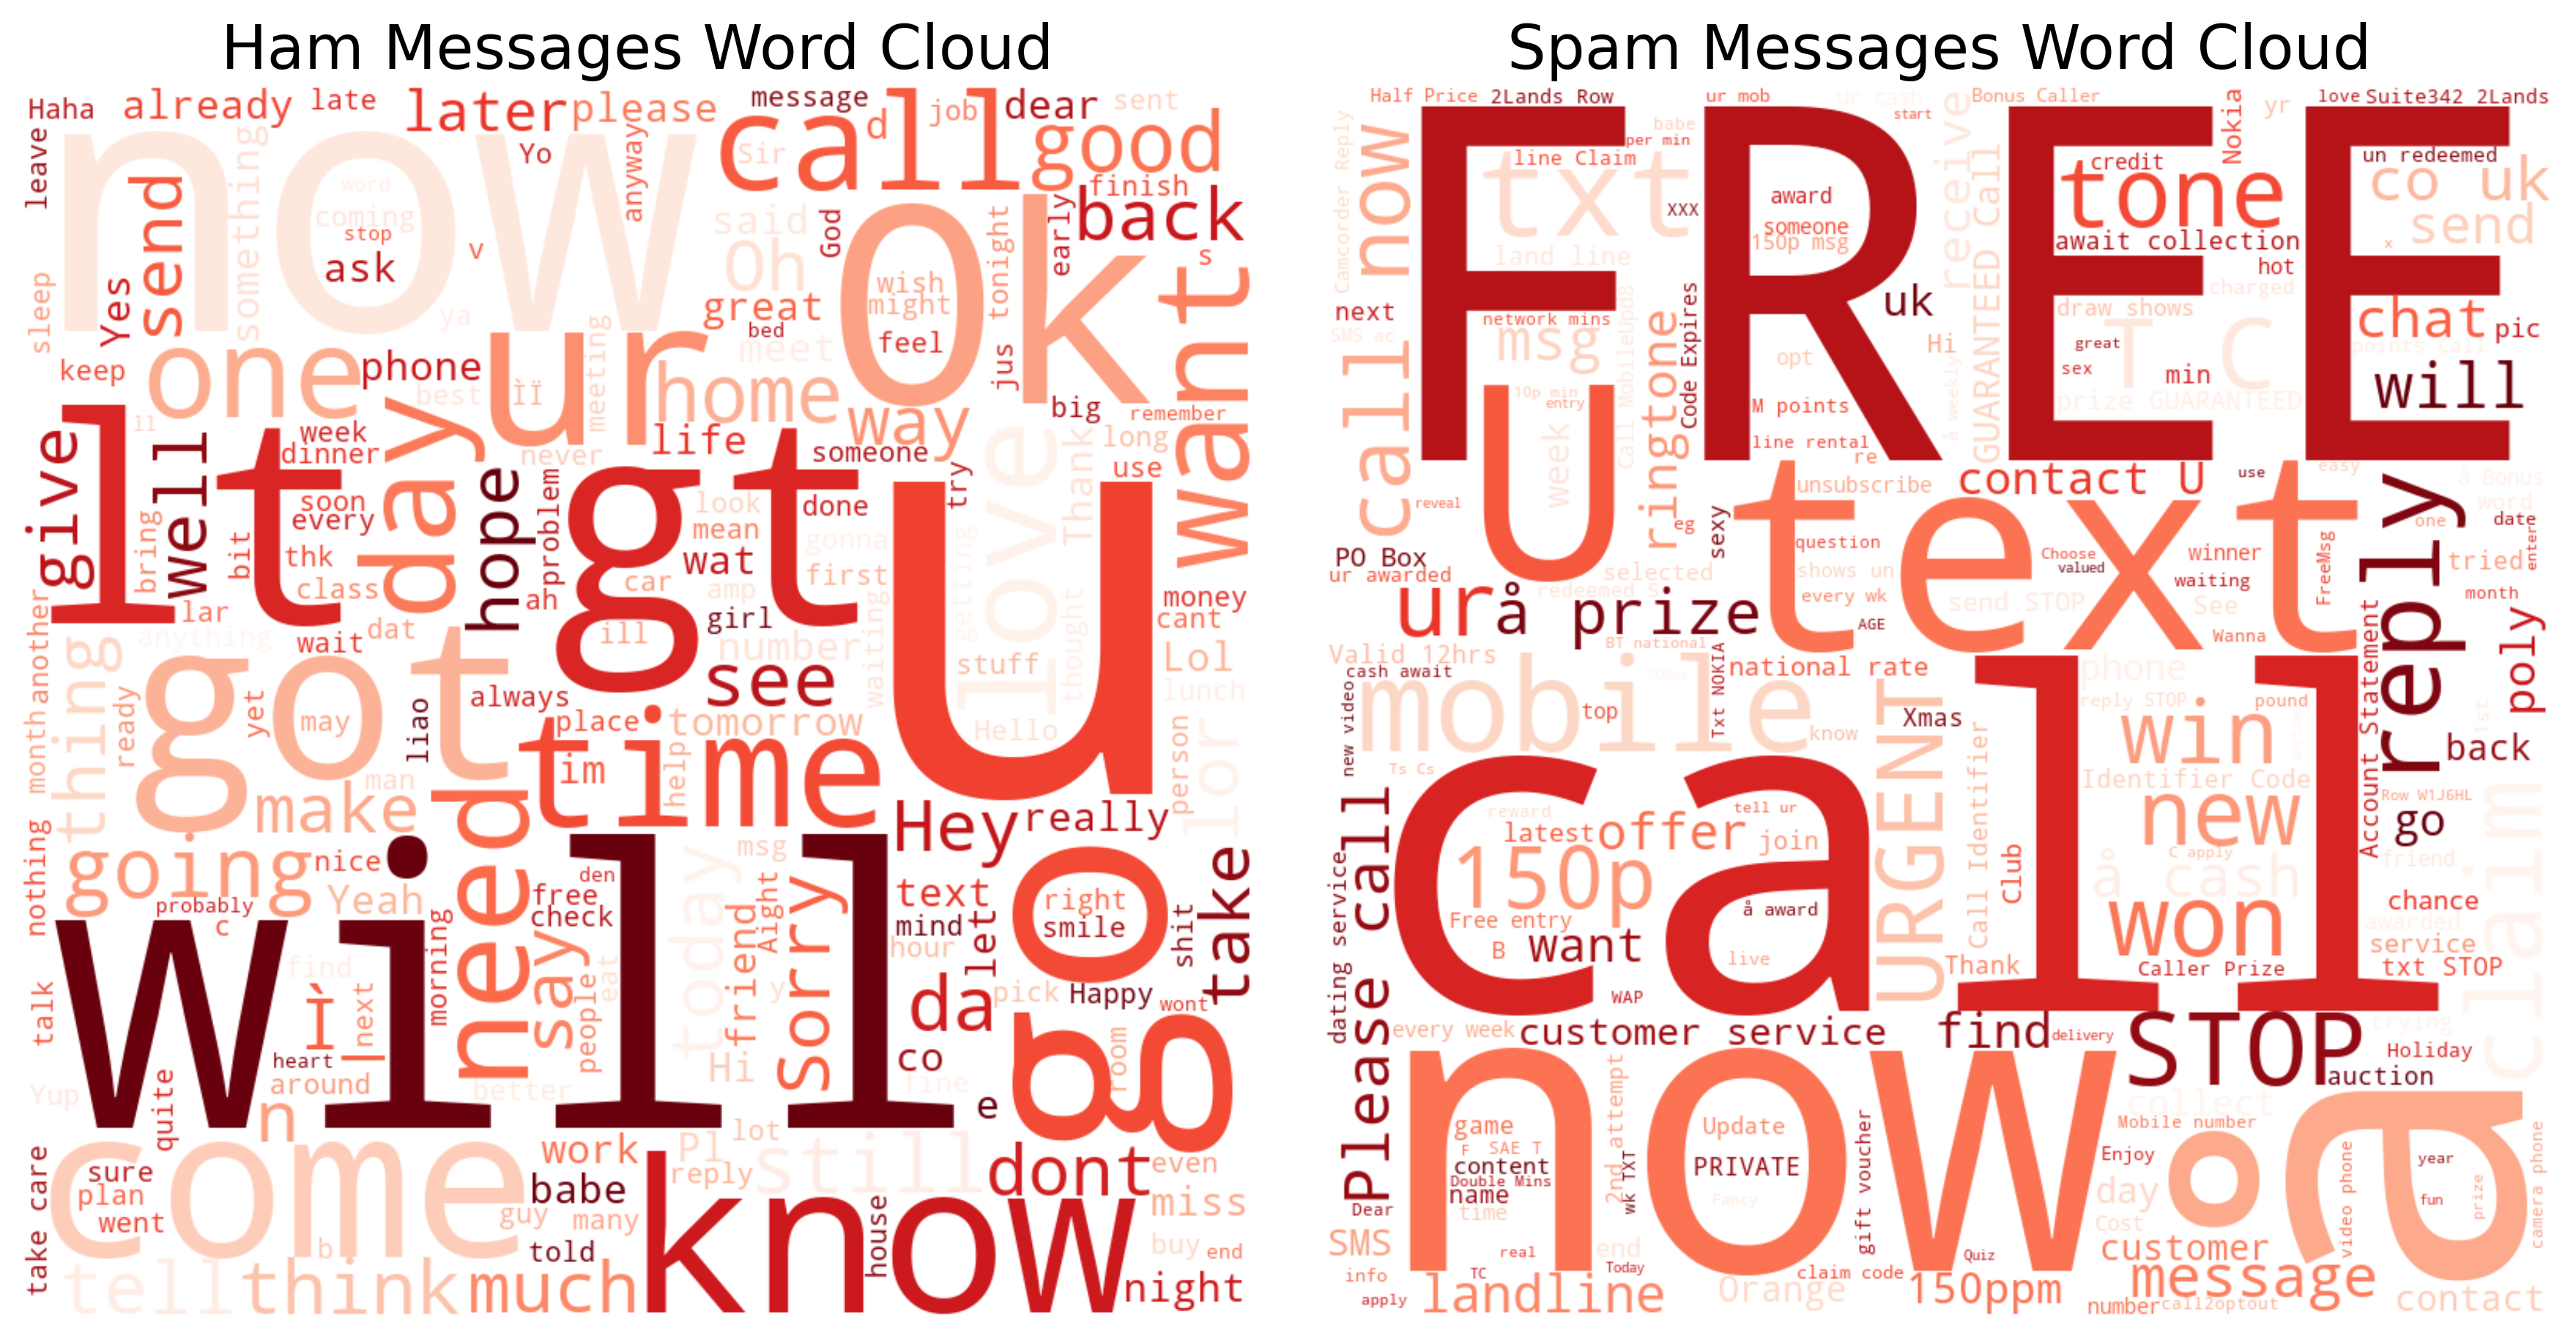

In [20]:
red_palette_c = sns.color_palette("Reds_r", as_cmap=True)

ham_text = " ".join(df[df['Class'] == "ham"]['Text'].astype(str))
spam_text = " ".join(df[df['Class'] == "spam"]['Text'].astype(str))


ham_wordcloud = WordCloud(width=800, height=800, background_color='white', colormap=red_palette_c).generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=800, background_color='white', colormap=red_palette_c).generate(spam_text)

ham_image = ham_wordcloud.to_array()
spam_image = spam_wordcloud.to_array()

plt.figure(figsize=(12, 6), dpi=300)

plt.subplot(1, 2, 1)
plt.imshow(ham_image, interpolation='bilinear')
plt.title('Ham Messages Word Cloud', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_image, interpolation='bilinear')
plt.title('Spam Messages Word Cloud', fontsize=20)
plt.axis('off')

plt.tight_layout()

# # Save the plot with higher quality
plt.savefig('../../../Data/English/1. Main/Word Cloud.png', format='png', dpi=1000)

plt.show()


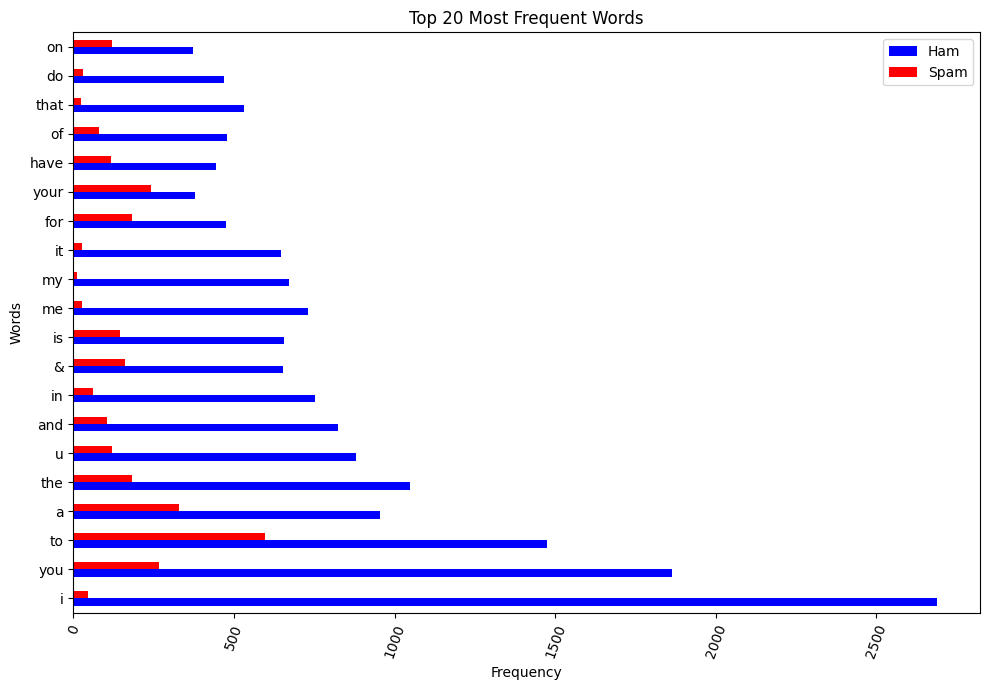

In [21]:

# Function to clean and tokenize the text for English
def clean_and_tokenize(text):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)
    unwanted_patterns = r'[\/:?\.\,;!"]|^\d+$|^(https?|www)$'
    tokens = [token for token in tokens if not re.match(unwanted_patterns, token)]
    return tokens

# Prepare and clean text
ham_text = " ".join(df[df['Class'] == "ham"]['Text'].astype(str))
spam_text = " ".join(df[df['Class'] == "spam"]['Text'].astype(str))
ham_words = clean_and_tokenize(ham_text)
spam_words = clean_and_tokenize(spam_text)

# Calculate term frequency and combine into a single DataFrame
ham_word_counts = pd.Series(ham_words).value_counts()
spam_word_counts = pd.Series(spam_words).value_counts()
combined_word_counts = pd.DataFrame({'Ham': ham_word_counts, 'Spam': spam_word_counts}).fillna(0)

# Calculate the total frequency for sorting
combined_word_counts['Total'] = combined_word_counts.sum(axis=1)

# Sort the DataFrame by total frequency
combined_word_counts = combined_word_counts.sort_values(by='Total', ascending=False)

# Get the top 20 most frequent words
top_words = combined_word_counts.head(20)

# Drop the 'Total' column after sorting
top_words = top_words.drop(columns='Total')

# Plot term frequency bar chart for the top 20 most frequent words
fig, ax = plt.subplots(figsize=(10, 7))

top_words.plot(kind='barh', ax=ax, color=['blue', 'red'])
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.xticks(rotation=70, ha='center')

plt.tight_layout()

# # Save the plot with higher quality
plt.savefig('../../../Data/English/1. Main/Top 20 most Frequent Words.png', format='png', dpi=1000)

plt.show()

### Let's define some functions for preprocessing.

In [22]:
def remove_urls(text):
    """Replaces URLs in the text with <URL>."""
    extractor = URLExtract()
    urls = extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, "<URL>")
    return text

def normalize_text(text):
    """Normalizes the text: lowercasing, removing punctuation."""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text
# ***** remember that you should make the puntuation handeling integerated. ****
def handle_punctuation(text):
    """Handles punctuation by removing unwanted characters."""
    unwanted_patterns = r'[\/:?\.\,;!\"\'()-]'
    return re.sub(unwanted_patterns, '', text)

def tokenize_text(text):
    """Tokenizes the text using NLTK word tokenizer."""
    return word_tokenize(text)

def lemmatize_tokens(tokens):
    """Lemmatizes each token in the list."""
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def remove_stopwords(tokens):
    """Removes stopwords from the list of tokens."""
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]

def join_tokens(tokens):
    """Joins the list of tokens back into a sentence."""
    return ' '.join(tokens)

### next, I'll preprocess each step separately, using progress bars to track each one. After completing each step, I'll save the changes to a separate CSV file, so if the process stops unexpectedly, I can resume from the last completed step without starting over.

In [23]:
# tqdm.pandas()

# # Step 1: Remove URLs
# print("Removing URLs......")
# df['Text'] = df['Text'].progress_apply(remove_urls)
# df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_english_sms.csv', index=False)

# # Step 2: Normalize text
# print("Normalizing text.......")
# df['Text'] = df['Text'].progress_apply(normalize_text)
# df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_english_sms.csv', index=False)

# # Step 3: Handle punctuation
# print("Handling punctuation.......")
# df['Text'] = df['Text'].progress_apply(handle_punctuation)
# df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_english_sms.csv', index=False)

# # Step 4: Tokenize text
# print("Tokenizing text.......")
# df['Tokens'] = df['Text'].progress_apply(tokenize_text)
# df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_english_sms.csv', index=False)

# # Step 5: Lemmatize tokens
# print("Lemmatizing tokens.......")
# df['Tokens'] = df['Tokens'].progress_apply(lemmatize_tokens)
# df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_english_sms.csv', index=False)

# # Step 6: Remove stopwords
# print("Removing stopwords.......")
# df['Tokens'] = df['Tokens'].progress_apply(remove_stopwords)
# df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_english_sms.csv', index=False)

# # Step 7: Join tokens back into a sentence
# print("Joining tokens back into a sentence.......")
# df['Text'] = df['Tokens'].progress_apply(join_tokens)
# df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_english_sms.csv', index=False)

# print("Preprocessing complete and saved at each step.")

In [24]:
# Load the latest preprocessed CSV file::
df = pd.read_csv("../../../Data/English/3. Preprocessed/preprocessed_english_sms.csv", encoding='UTF-8')

In [25]:
df

,Class,Text,NO_words,NO_characters,NO_sentences,Tokens
0,ham,go jurong point crazi avail onli bugi n great ...,24,111,2,"['go', 'jurong', 'point', 'crazi', 'avail', 'o..."
1,ham,ok lar joke wif u oni,8,29,2,"['ok', 'lar', 'joke', 'wif', 'u', 'oni']"
2,spam,free entri 2 wkli comp win fa cup final tkt 21...,37,155,2,"['free', 'entri', '2', 'wkli', 'comp', 'win', ..."
3,ham,u dun say earli hor u c alreadi say,13,49,1,"['u', 'dun', 'say', 'earli', 'hor', 'u', 'c', ..."
4,ham,nah dont think goe usf live around though,15,61,1,"['nah', 'dont', 'think', 'goe', 'usf', 'live',..."
...,...,...,...,...,...,...
5164,spam,thi 2nd time tri 2 contact u u å750 pound priz...,35,161,4,"['thi', '2nd', 'time', 'tri', '2', 'contact', ..."
5165,ham,ì_ b go esplanad fr home,9,37,1,"['ì_', 'b', 'go', 'esplanad', 'fr', 'home']"
5166,ham,piti wa mood soani suggest,15,57,2,"['piti', 'wa', 'mood', 'soani', 'suggest']"
5167,ham,guy bitch act like id interest buy someth els ...,27,125,1,"['guy', 'bitch', 'act', 'like', 'id', 'interes..."


In [26]:
# Replace text labels 'ham' and 'spam' with 0 and 1 in the 'Class' column
df["Class"].replace({"ham": 0, "spam": 1}, inplace=True)

In [27]:
# Drop rows with missing values in the 'Text' column
df = df.dropna(subset=['Text'])

# Text Vectorization using TF-IDF for the 'Text' Column
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(df['Text'])
Y = df["Class"]


In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

In [29]:
# Classifier models
svm = SVC(kernel='sigmoid', gamma=1.0, class_weight='balanced')
knn = KNeighborsClassifier()
mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()
dt = DecisionTreeClassifier(max_depth=5)
lr = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced')
rf = RandomForestClassifier(n_estimators=50, random_state=2, class_weight='balanced')
ada = AdaBoostClassifier(n_estimators=50, random_state=2)
bagging = BaggingClassifier(n_estimators=50, random_state=2)
et = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2, tree_method='gpu_hist')
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
ridge = RidgeClassifier()
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=2)
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=2)


In [30]:
# Add models to the dictionary
models = {
    'SVM': svm,
    'KNN': knn,
    'MultinomialNB': mnb,
    'GaussianNB': gnb,
    'BernoulliNB': bnb,
    'DT': dt,
    'LR': lr,
    'RF': rf,
    'AdaBoost': ada,
    'Bagging': bagging,
    'ExtraTrees': et,
    'GBDT': gbdt,
    'XGB': xgb,
    'LDA': lda,
    'QDA': qda,
    'Ridge': ridge,
    'SGD': sgd,
    'Perceptron': perceptron
}

In [31]:
def train_classifier(model, X_train, Y_train, X_test, Y_test, dense_data=None):
    # Use precomputed dense data if provided
    if isinstance(model, (GaussianNB, QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis)):
        if dense_data is None:
            print(f"Converting sparse data to dense for {type(model).__name__}")
            X_train = X_train.toarray()
            X_test = X_test.toarray()
        else:
            X_train, X_test = dense_data
    
    # Train the model
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='binary')
    recall = recall_score(Y_test, y_pred, average='binary')
    f1 = f1_score(Y_test, y_pred, average='binary')
    return accuracy, precision, recall, f1, y_pred

.

.


.


.

.
---

### Explanation of the following Code  

This cell performs the following tasks:

1. **Logging Setup**:
   - The `logging` module is used to log messages during the training process.
   - The logging level is set to `INFO`, which means informational messages (e.g., training progress and results) will be displayed, while debug messages will be ignored.

2. **Sequential Model Training**:
   - The models in the `models` dictionary are trained one by one using the `train_classifier` function.
   - For each model:
     - The function computes the performance metrics: **Accuracy**, **Precision**, **Recall**, and **F1 Score**.
     - These metrics, along with the model name, are stored in the `results` list as tuples.

3. **Error Handling**:
   - If an error occurs while training a model, it is logged using `logger.error`, and the training process continues with the next model.

4. **Logging Final Results**:
   - After all models are trained, the final performance metrics for each model are logged in a clean and concise format.

### Purpose:
This cell ensures that:
- All models are trained sequentially.
- Errors during training are logged without stopping the entire process.
- The performance metrics for each model are logged for easy comparison.

---

In [32]:
# Enable logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Train models sequentially
results = []
for name, model in models.items():
    try:
        accuracy, precision, recall, f1, y_pred = train_classifier(model, X_train, Y_train, X_test, Y_test)
        results.append((name, accuracy, precision, recall, f1))
    except Exception as e:
        logger.error(f"Error occurred while training model {name}: {e}")

# Log final results
logger.info("\nFinal Results:")
for name, accuracy, precision, recall, f1 in results:
    logger.info(f"{name}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

Converting sparse data to dense for GaussianNB
Converting sparse data to dense for LinearDiscriminantAnalysis
Converting sparse data to dense for QuadraticDiscriminantAnalysis


INFO:__main__:
Final Results:
INFO:__main__:SVM: Accuracy=0.9787, Precision=0.9658, Recall=0.8626, F1 Score=0.9113
INFO:__main__:KNN: Accuracy=0.8867, Precision=1.0000, Recall=0.1069, F1 Score=0.1931
INFO:__main__:MultinomialNB: Accuracy=0.9409, Precision=1.0000, Recall=0.5344, F1 Score=0.6965
INFO:__main__:GaussianNB: Accuracy=0.9264, Precision=0.6519, Recall=0.9008, F1 Score=0.7564
INFO:__main__:BernoulliNB: Accuracy=0.9274, Precision=0.9667, Recall=0.4427, F1 Score=0.6073
INFO:__main__:DT: Accuracy=0.9458, Precision=0.9121, Recall=0.6336, F1 Score=0.7477
INFO:__main__:LR: Accuracy=0.9700, Precision=0.8968, Recall=0.8626, F1 Score=0.8794
INFO:__main__:RF: Accuracy=0.9593, Precision=1.0000, Recall=0.6794, F1 Score=0.8091
INFO:__main__:AdaBoost: Accuracy=0.9303, Precision=0.8471, Recall=0.5496, F1 Score=0.6667
INFO:__main__:Bagging: Accuracy=0.9632, Precision=0.9115, Recall=0.7863, F1 Score=0.8443
INFO:__main__:ExtraTrees: Accuracy=0.9710, Precision=1.0000, Recall=0.7710, F1 Score=0.87

In [33]:
# Create a DataFrame to store and compare the accuracy, precision, recall, and F1 scores of the different algorithms
performance_df = pd.DataFrame({
    'Algorithm': [name for name, _, _, _, _ in results],
    'Accuracy': [accuracy for _, accuracy, _, _, _ in results],
    'Precision': [precision for _, _, precision, _, _ in results],
    'Recall': [recall for _, _, _, recall, _ in results],
    'F1 Score': [f1 for _, _, _, _, f1 in results]
})

In [34]:
# Sort the DataFrame by 'F1 Score' in descending order
performance_df = performance_df.sort_values('F1 Score', ascending=False)

# Reset the index to ensure it is sequential
performance_df = performance_df.reset_index(drop=True)

performance_df

,Algorithm,Accuracy,Precision,Recall,F1 Score
0,Perceptron,0.981607,0.951613,0.900763,0.925490
1,SVM,0.978703,0.965812,0.862595,0.911290
2,SGD,0.978703,0.990991,0.839695,0.909091
3,XGB,0.972894,0.925620,0.854962,0.888889
4,LR,0.969990,0.896825,0.862595,0.879377
5,ExtraTrees,0.970958,1.000000,0.770992,0.870690
6,Ridge,0.969022,0.980583,0.770992,0.863248
7,Bagging,0.963214,0.911504,0.786260,0.844262
8,GBDT,0.959342,0.978495,0.694656,0.812500
9,RF,0.959342,1.000000,0.679389,0.809091



---

### **Comparison of Model Performance Before and After Changes**

#### **Key Observations**
1. **Top Performers**:
   - **Perceptron** achieved the highest **F1 Score** of `0.925490` after the changes, compared to `0.866071` before.
   - **SVM** and **SGD** maintained strong performance, with slight improvements in **F1 Score**.
   - **XGBClassifier** also showed a noticeable improvement in **F1 Score**.

2. **Improved Models**:
   - **Logistic Regression** saw a significant improvement in **F1 Score** (`0.879377` vs. `0.597826`).
   - **ExtraTreesClassifier** and **RidgeClassifier** also performed better after the changes.

3. **Underperformers**:
   - **KNN**, **LDA**, and **QDA** consistently underperformed, with very low **F1 Scores**.

#### **Impact of Changes**
- Sparse-to-dense conversion allowed models like **LDA**, **QDA**, and **GaussianNB** to run successfully, but their performance remained suboptimal.
- Sequential training ensured stability and avoided delays caused by parallelization.
- Improved logging and results handling made it easier to analyze and compare model performance.

#### **Recommendations**
1. Focus on top-performing models (**Perceptron**, **SVM**, **SGD**, **XGBClassifier**, **Logistic Regression**) for further tuning.
2. Exclude poor performers (**KNN**, **LDA**, **QDA**) from further analysis.
3. Perform hyperparameter tuning and explore additional feature engineering techniques to further improve results.

---
.
.


.


.

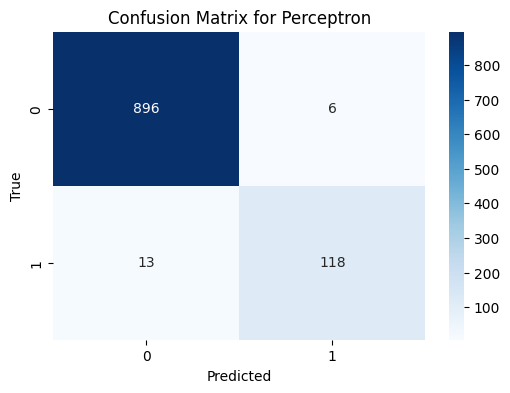

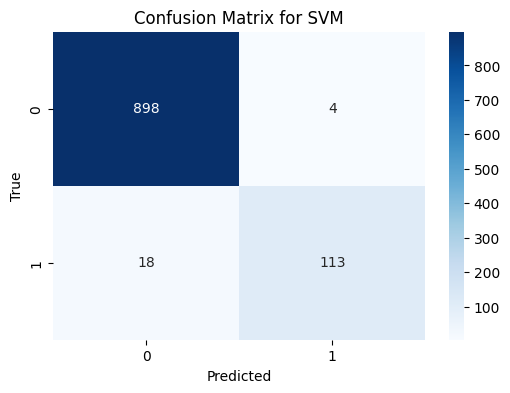

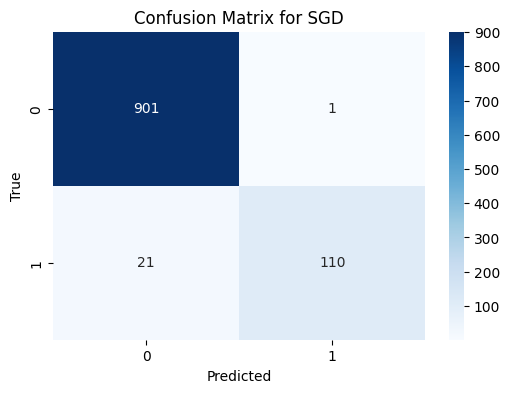

In [35]:
# Plot confusion matrices for top 3 models
top_models = performance_df.head(3)['Algorithm']
for name in top_models:
    model = models[name]
    _, _, _, _, y_pred = train_classifier(model, X_train, Y_train, X_test, Y_test)
    cm = confusion_matrix(Y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

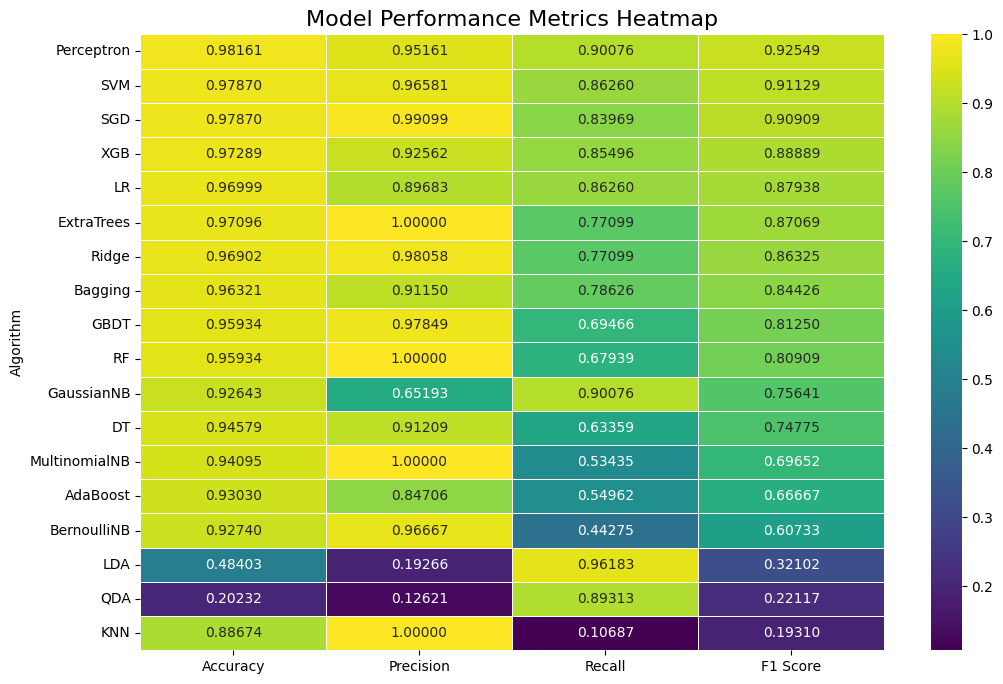

In [39]:
#  Heatmap
plt.figure(figsize=(12, 8))
metrics = performance_df.set_index('Algorithm')[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
sns.heatmap(metrics, annot=True, cmap='viridis', fmt=".5f", linewidths=0.5)
plt.title('Model Performance Metrics Heatmap', fontsize=16)

# Save the chart as an image
plt.savefig('Results/Train_english_sms/heatmap_model_performance_chart.png', dpi=600, bbox_inches='tight')

# Show the chart
plt.show()

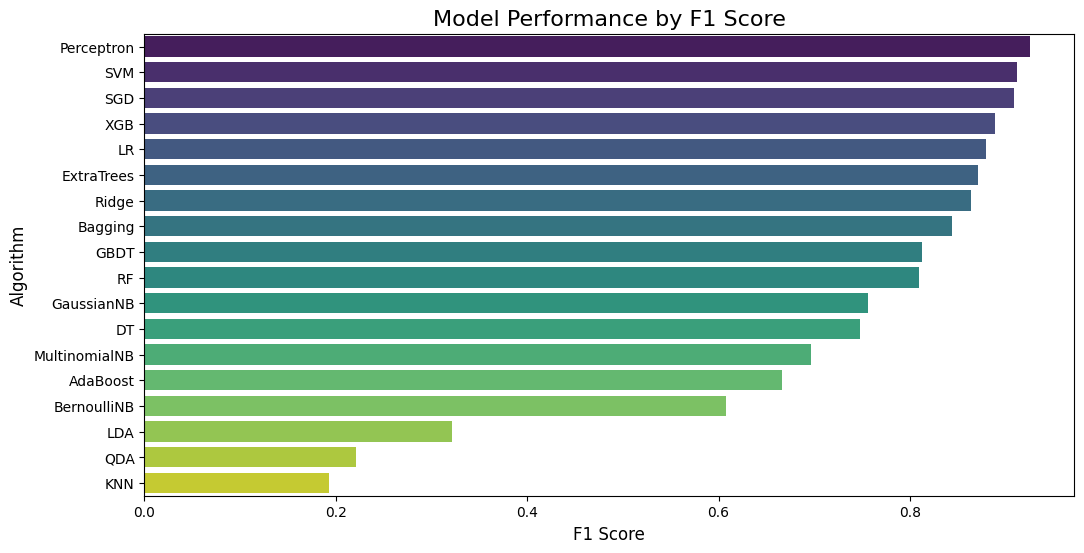

In [37]:
# Bar plot for F1 Score
plt.figure(figsize=(12, 6))
sns.barplot(x='F1 Score', y='Algorithm', data=performance_df, palette='viridis')
plt.title('Model Performance by F1 Score', fontsize=16)
plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Algorithm', fontsize=12)

# Save the chart as an image
plt.savefig('Results/Train_english_sms/barplot_model_performance.png', dpi=600, bbox_inches='tight')

# Show the chart
plt.show()